# Fine tunning de redes pre-entranadas

Los experimentos realizados en este notebook se basan en las indicaciones de este [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

La idea, básimente consiste en:
1. coger una red ya entrenada previamente y quitarle la capa superior
2. clasificar nuestro conjunto de datos con la red resultante del paso anterior
3. diseñar un modelo sencillo cuyo input es el output del punto 2 y entrenarlo

Aparentemente con muy poco cálculo se pueden obtener buenos resultados.

En los siguientes experimentos voy a probar el planteamiento anterior utilizando las redes pre-entrenadas que vienen con defecto con Keras para ver cual de ellas ofrece mejores resultados.

Después, una vez seleccionada una, intentaré determinar el optimizar el diseño del modelo superior.

## Parámetros comunes para todos los experimentos

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import json
import requests
from os.path import expanduser
import tarfile
from keras import applications
from keras.layers import Dropout, Flatten, Dense, Input
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator

intermediate_data_url = 'https://www.dropbox.com/s/fsqh2emxq8kp80i/intermediate-data.tar.gz?dl=1'

train_data_dir = '../data/train'
validation_data_dir = '../data/validation'

train_features_path = '{}_train_features.npy'
train_labels_path = '{}_train_labels.npy'
validation_features_path = '{}_validation_features.npy'
validation_labels_path = '{}_validation_labels.npy'
top_model_path = '{}_top_model.h5'
history_path = '{}_history.json'

# TODO: set properly
width, height = 200, 200
train_samples = 1152
validation_samples = 288
categories = 21
batch_size = 4
epochs = 20

Using TensorFlow backend.


## Generación de datos

Definimos unas funciones que, dado un modelo pre-entrenado, permiten traducir nuestros datos en carácterísticas y etiquetas para utilizarse en el top model.

Primero para los datos de entrenamiento:

In [2]:
def generate_train_data(name, model):
    
    print 'generating training data for %s' % name
    
    naive_datagen = ImageDataGenerator(rescale=1. / 255)    
    dataflow = naive_datagen.flow_from_directory(train_data_dir, 
                                                 batch_size=batch_size, 
                                                 class_mode='categorical',
                                                 target_size=(width, height),
                                                 shuffle=False)

    features = None
    labels = None    
    rounds = train_samples // batch_size
    print 'running {} rounds'.format(rounds)
    for i in range(rounds):
        if i % 50 == 0:
            print
            print i,'/',rounds,'.',
        else:
            print '.',
        batch = dataflow.next()
        batch_features = model.predict(batch[0])
        batch_labels = batch[1]

        if features is None:
            features = batch_features
        else:
            features = np.append(features,batch_features,axis=0)

        if labels is None:
            labels = batch_labels
        else:
            labels = np.append(labels,batch_labels,axis=0)
    print 'done'
    
    np.save(open(train_features_path.format(name), 'w'), features)
    np.save(open(train_labels_path.format(name), 'w'), labels)

Y ahora para los datos de prueba:

In [3]:
def generate_validation_data(name, model):
    
    print 'generating validation data for %s' % name
    
    naive_datagen = ImageDataGenerator(rescale=1. / 255)    
    dataflow = naive_datagen.flow_from_directory(validation_data_dir, 
                                                 batch_size=batch_size, 
                                                 class_mode='categorical',
                                                 target_size=(width, height),
                                                 shuffle=False)

    features = None
    labels = None    
    rounds = validation_samples // batch_size
    print 'running {} rounds'.format(rounds)
    for i in range(rounds):
        if i % 50 == 0:
            print
            print i,'/',rounds,'.',
        else:
            print '.',
        batch = dataflow.next()
        batch_features = model.predict(batch[0])
        batch_labels = batch[1]

        if features is None:
            features = batch_features
        else:
            features = np.append(features,batch_features,axis=0)

        if labels is None:
            labels = batch_labels
        else:
            labels = np.append(labels,batch_labels,axis=0)
    print 'done'
    
    np.save(open(validation_features_path.format(name), 'w'), features)
    np.save(open(validation_labels_path.format(name), 'w'), labels)

Definimos unas utilidades para dibujar métricas de los experimentos.

In [4]:
def plot_history(name):
    
    history = json.load(open(history_path.format(name)))
    
    plt.figure(figsize=(12, 4))
    
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title(name + ' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(name + ' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    
    plt.suptitle(name,y=1.05,fontsize=16)
    plt.tight_layout()
    plt.show()    
    
def plot_histories(names):
    
    plt.figure(figsize=(24, 8))    
    
    for i in range(len(names)):
        name = names[i]
        history = json.load(open(history_path.format(name)))        
        plt.subplot(121)
        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
    
    plt.title('model accuracies',fontsize=16)    
    plt.ylabel('accuracy')
    plt.xlabel('epoch')        
    plt.legend([j for i in [[name + ' train', name + ' test'] for name in names] 
                for j in i], 
               loc='upper left')
    plt.grid(True)  
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(24, 8))    
    
    for i in range(len(names)):
        name = names[i]
        history = json.load(open(history_path.format(name)))        
        plt.subplot(121)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
    
    plt.title('model losses',fontsize=16)    
    plt.ylabel('loss')
    plt.xlabel('epoch')        
    plt.legend([j for i in [[name + ' train', name + ' test'] for name in names] 
                for j in i], 
               loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()    

Y utilidades para reusar los datos intermedios ya calculados - disponibles en [dropbox](https://www.dropbox.com/s/fsqh2emxq8kp80i/intermediate-data.tar.gz?dl=0):

In [5]:
def get_intermediate_data(file_name):
    
    directory = expanduser("~") + '/.DMdeeplearning'
    if not os.path.exists(directory):
        os.makedirs(out)
        
    file_path = directory + '/intermediate-data.tar.gz'
    if not os.path.exists(file_path):
        print 'downloading tmp data (will take a moment) ... '        
        r = requests.get(intermediate_data_url, stream=True)
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: 
                    f.write(chunk)
                
    tar = tarfile.open(file_path)
    return tar.extractfile(file_name)

## Top model común

In [6]:
def common_top_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(categories, activation='softmax'))
    return model

## Ejecutor de experimentos

In [7]:
def run_experiment(name, top_model=None, epochs=epochs):    
    
    print 'starting %s experiment' % name
    
    # stops if already done
    if os.path.isfile(top_model_path.format(name)) :
        return    
    
    data = name.split('_')[0]
    
    print 'loading intermediate data for %s' % name
    names = [train_features_path.format(data),
             train_labels_path.format(data),
             validation_features_path.format(data),
             validation_labels_path.format(data)]
    files = [get_intermediate_data(n) for n in names]
    train_features = np.load(files[0])
    train_labels = np.load(files[1])
    validation_features = np.load(files[2])
    validation_labels = np.load(files[3])

    print 'shapes for %s: ' % name
    print '\t',train_features.shape
    print '\t',train_labels.shape
    print '\t',validation_features.shape
    print '\t',validation_labels.shape
              
    print 'training top model for %s' % name
    
    if top_model is None:
        top_model = common_top_model(train_features.shape[1:])
        
    top_model.compile(
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    history = top_model.fit(train_features,
                            train_labels,
                            batch_size=batch_size,
                            nb_epoch=epochs,
                            validation_data=(validation_features, validation_labels))
              
    print 'saving top model for %s' % name
    top_model.save(top_model_path.format(name))    
    
    print 'saving history for %s' % name    
    json.dump(history.history, open(history_path.format(name),'w'))
    
    print '%s done!' % name

## Experimentos "naive" con distintas redes pre-entrenadas
### VGG16

In [8]:
def VGG16_exp1():    
    name = 'VGG16_exp1'       
    if os.path.isfile(top_model_path.format(name)) :
        print 'el experimento %s parece que ya se ha realizado' % name
        return
    # Sólo se genera la primera vez
    # input_tensor=Input(shape=(width,height,3))
    # model = applications.VGG16(include_top=False, weights='imagenet',input_tensor=input_tensor)
    # generate_train_data(name, model)
    # generate_validation_data(name, model)
    run_experiment(name)

VGG16_exp1()

el experimento VGG16_exp1 parece que ya se ha realizado


### VGG19

In [9]:
def VGG19_exp1():    
    name = 'VGG19_exp1'       
    if os.path.isfile(top_model_path.format(name)) :
        print 'el experimento %s parece que ya se ha realizado' % name
        return
    # Sólo se genera la primera vez
    # input_tensor=Input(shape=(width,height,3))
    # model = applications.VGG19(include_top=False, weights='imagenet',input_tensor=input_tensor)
    # generate_train_data(name, model)
    # generate_validation_data(name)
    run_experiment(name)

VGG19_exp1()

el experimento VGG19_exp1 parece que ya se ha realizado


### InceptionV3

In [10]:
def InceptionV3_exp1():    
    name = 'InceptionV3_exp1'   
    if os.path.isfile(top_model_path.format(name)) :
        print 'el experimento %s parece que ya se ha realizado' % name  
        return
    # Sólo se genera la primera vez
    # input_tensor=Input(shape=(width,height,3))
    # model = applications.InceptionV3(include_top=False,weights='imagenet',input_tensor=input_tensor)
    # generate_train_data(name, model)
    # generate_validation_data(name)
    run_experiment(name)
    
InceptionV3_exp1()

el experimento InceptionV3_exp1 parece que ya se ha realizado


### ResNet50

In [11]:
def ResNet50_exp1():    
    name = 'ResNet50_exp1'      
    if os.path.isfile(top_model_path.format(name)) :
        print 'el experimento %s parece que ya se ha realizado' % name 
        return
    # Sólo se genera la primera vez
    # input_tensor=Input(shape=(width,height,3))
    # model = applications.ResNet50(include_top=False,weights='imagenet',input_tensor=input_tensor)
    # generate_train_data(name, model)
    # generate_validation_data(name, model)
    run_experiment(name)
    
ResNet50_exp1()

el experimento ResNet50_exp1 parece que ya se ha realizado


### Xception

In [12]:
def Xception_exp1():    
    name = 'Xception_exp1'     
    if os.path.isfile(top_model_path.format(name)) :
        print 'el experimento %s parece que ya se ha realizado' % name  
        return
    # Sólo se genera la primera vez
    # input_tensor=Input(shape=(width,height,3))
    # model = applications.Xception(include_top=False,weights='imagenet',input_tensor=input_tensor)    
    # generate_train_data(name, model)
    # generate_validation_data(name)
    run_experiment(name)
    
# Xception_exp1()

La generación de los datos temporales para cada modelo de los anteriores sólo es necesario realiarla un ver para un mismo datagen. Lleva bastante tiempo y genera archivos grandes, que pueden saturar el repositorio en github.

Por eso, los he generado yo una sóla ve y están disponibles en [dropbox](https://www.dropbox.com/s/fsqh2emxq8kp80i/intermediate-data.tar.gz?dl=0).

## Resultado de los experimentos "naive"

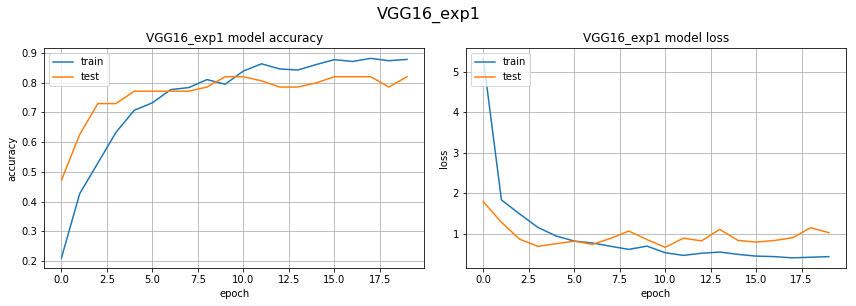

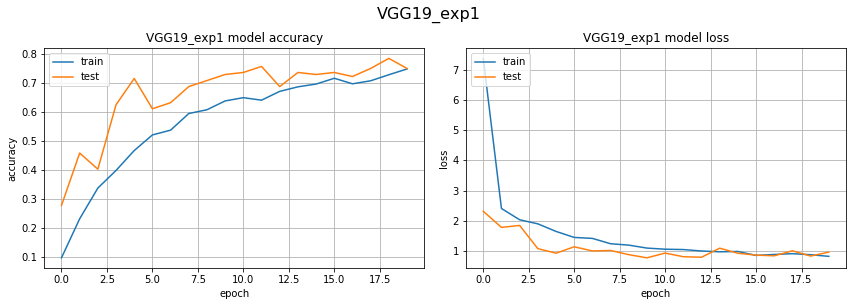

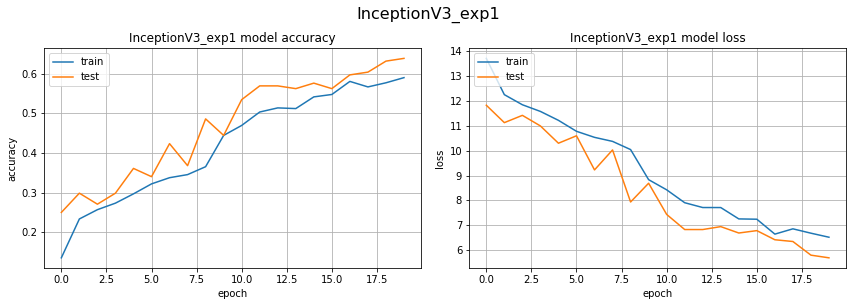

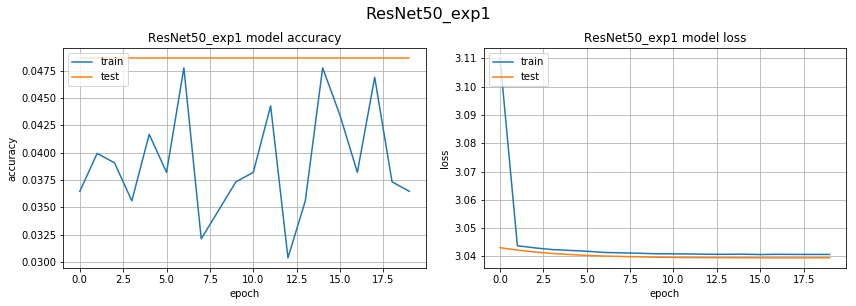

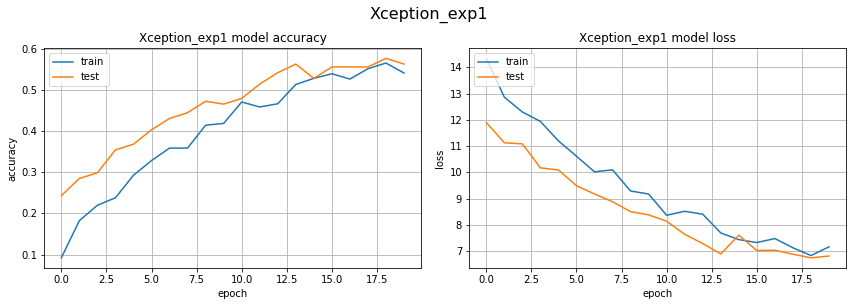

In [13]:
plot_history('VGG16_exp1')
print
plot_history('VGG19_exp1')
print
plot_history('InceptionV3_exp1')
print
plot_history('ResNet50_exp1')
print
plot_history('Xception_exp1')

**La primera conclusión clara es que la ResNet50 queda descartada.**

Para tener una visión más clara podemos dibujar conjuntamente las métricas anteriores.

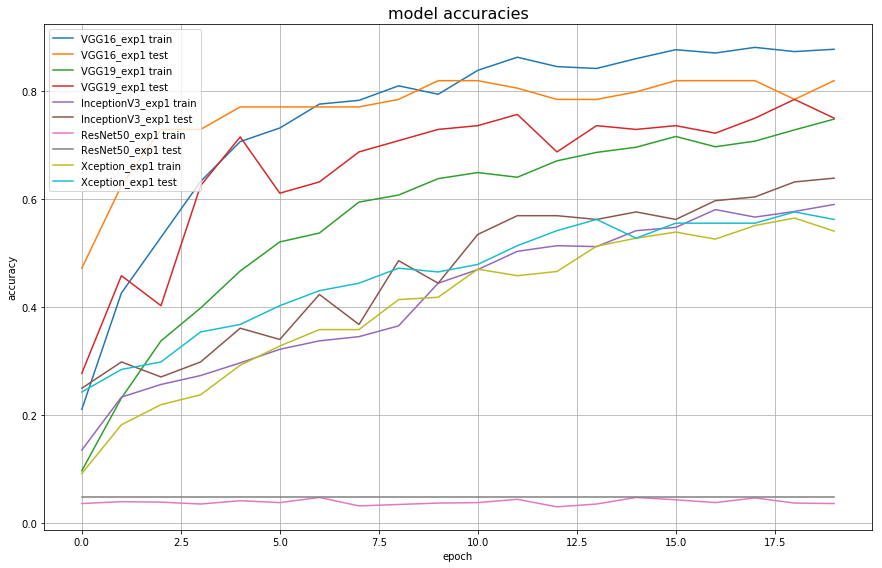

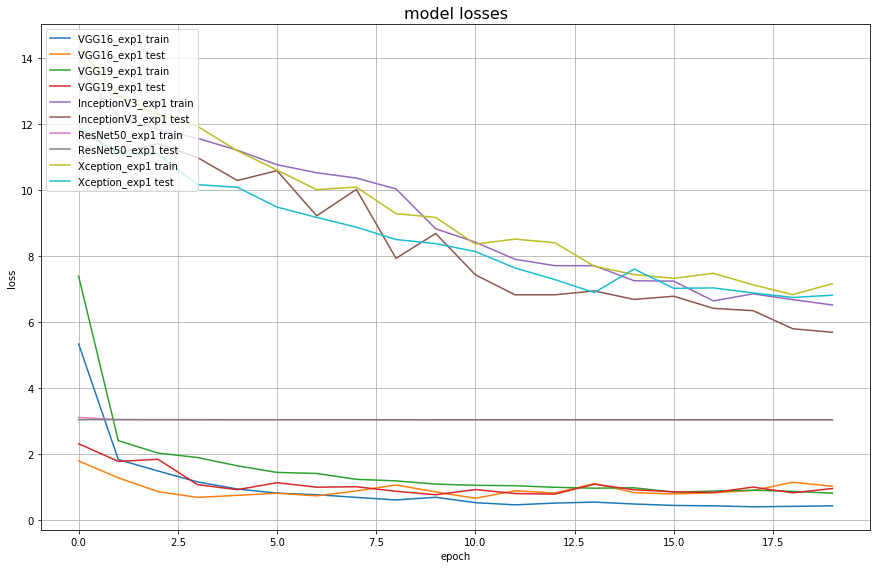

In [14]:
plot_histories(['VGG16_exp1','VGG19_exp1','InceptionV3_exp1','ResNet50_exp1','Xception_exp1'])

A la vista de esta comparativa, aparentemente la InceptionV3 parece ofrecer peores resultados que las VGG, que parecen comportarse de modo similar.

**Sin embargo, vemos que el poder de clasificación de las VGG se estanca entorno a las 10 épocas de entrenamiento, mientras que la InceptionV3 sigue mejorando a buen ritmo. Algo similar ocurre con la Xception**. Sin embargo, la red Xception ha generado un top model tan grande (200 MB), que ni siquiera lo puedo subir al repositorio. Por ahora no voy a centrarme en esta red. No la encuentro manejable, pues además es la que peor rendimiento tiene, y por ahora la descarto.

**Por lo tanto, voy a volver a entrenar el top model basado en la InceptionV3, pero esta vez con 100 épocas.**

## Segunda oportunidad a la InceptionV3, con 100 épocas

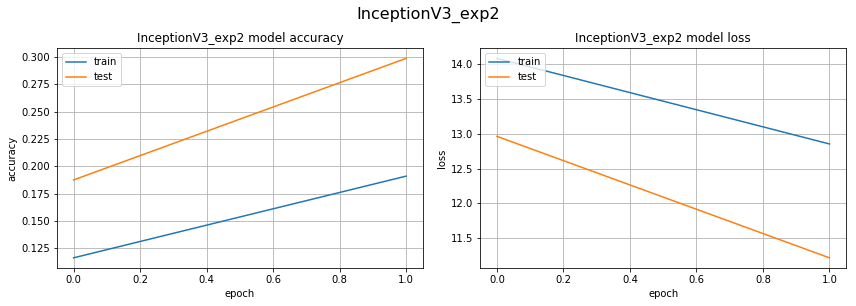

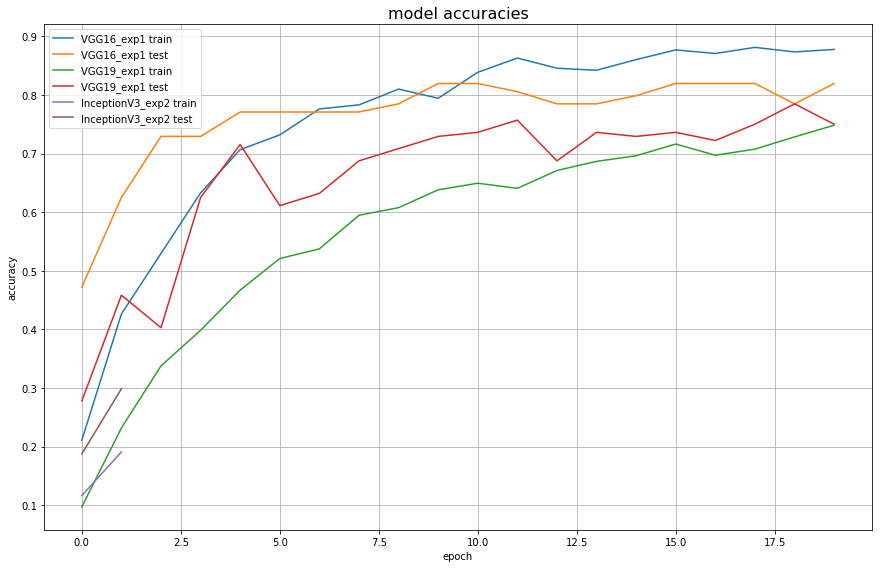

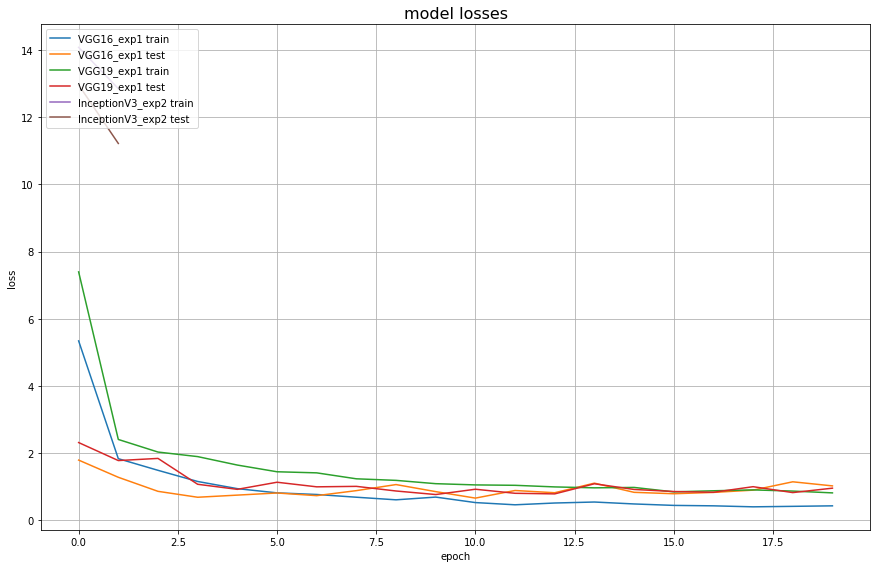

In [18]:
def InceptionV3_exp2():    
    name = 'InceptionV3_exp2'       
    if os.path.isfile(top_model_path.format(name)) :
        print 'el experimento %s parece que ya se ha realizado' % name
        return
    input_tensor=Input(shape=(width,height,3))
    model = applications.InceptionV3(include_top=False,weights='imagenet',input_tensor=input_tensor)
    run_experiment(name,epochs=100)
    
# TODO
# InceptionV3_exp2()
print
plot_history('InceptionV3_exp2')
print
plot_histories(['VGG16_exp1','VGG19_exp1','InceptionV3_exp2'])

# TODO: una vez elegida la mejor red, regenerar los datos intermedios con aumento y publicar el archivo